# Imports

In [1]:
import math
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sympy import *
import datetime as dt
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data as pdr

In [2]:
x = Symbol('x')
y = x**2 + 1
yprime = y.diff(x)
yprime

2*x

# Black Scholes

In [3]:
def d_p(S, K, T, t, r, sigma):
    return ( np.log( S / K ) + ( T - t ) * ( r + sigma ** 2 / 2 ) ) / ( sigma * math.sqrt( T - t ) )

def d_m(S, K, T, t, r, sigma):
    d_plus = d_p(S, K, T, t, r, sigma)
    return d_plus - sigma * math.sqrt( T - t )

d_p(50, 50, 90/365, 0, 0.05, 0.4)

0.16138314827746172

In [4]:
def black_scholes(S, K, T, t, r, sigma, option_type = 'call'):

    d_plus = d_p(S, K, T, t, r, sigma)
    d_minus = d_m(S, K, T, t, r, sigma)
    
    if option_type == 'call':
        return S * st.norm.cdf(d_plus) - K * math.exp( -r * ( T - t ) ) * st.norm.cdf(d_minus)
    elif option_type == 'put':
        return -S * st.norm.cdf(-d_plus) + K * math.exp( -r * ( T - t ) ) * st.norm.cdf(-d_minus)

# print(black_scholes(31.55, 22.75, 3.5, 0, 0.05, 0.5, 'call'))
black_scholes(200, 220, 1, 0, 0.05, 0.32, 'call')

21.63583763665305

# Greeks

In [5]:
# delta
def delta(S, K, T, t, r, sigma):
    d_plus = d_p(S, K, T, t, r, sigma)
    return st.norm.cdf(d_plus)

delta(200, 220, 1, 0, 0.05, 0.32)

0.5073423926222775

In [6]:
# gamma
def gamma(S, K, T, t, r, sigma):
    d_plus = d_p(S, K, T, t, r, sigma)
    return math.exp(-1 * d_plus ** 2 / 2) * 1 / (S * sigma * math.sqrt(2 * math.pi * (T - t)))

gamma(200, 220, 1, 0, 0.05, 0.32)

0.006232417365854552

In [7]:
def theta(S, K, T, t, r, sigma):
    d_plus = d_p(S, K, T, t, r, sigma)
    d_minus = d_m(S, K, T, t, r, sigma)
    term1 = math.exp(-1 * d_plus ** 2 / 2) * -1 * S * sigma / (2 * math.sqrt(2 * math.pi * (T - t)))
    # term1 = - (S * st.norm.pdf(d_plus) * sigma) / (2 * math.sqrt(T - t))
    term2 = r * K * math.exp(-r * (T - t)) * st.norm.cdf(d_minus)
    return term1 - term2
    

theta(200, 220, 1, 0, 0.05, 0.32)

-16.755622809660245

In [8]:
def vega(S, K, T, t, r, sigma):
    d_plus = d_p(S, K, T, t, r, sigma)
    return S * math.sqrt(T - t) / math.sqrt(2 * math.pi) * math.exp(-1 * d_plus ** 2 / 2)

vega(200, 220, 1, 0, 0.05, 0.32)

79.77494228293828

In [9]:
def rho(S, K, T, t, r, sigma):
    d_minus = d_m(S, K, T, t, r, sigma)
    return (T - t) * K * math.exp(-r * (T - t)) * st.norm.cdf(d_minus)

rho(200, 220, 1, 0, 0.05, 0.32)

79.83264088780246

# Graphs

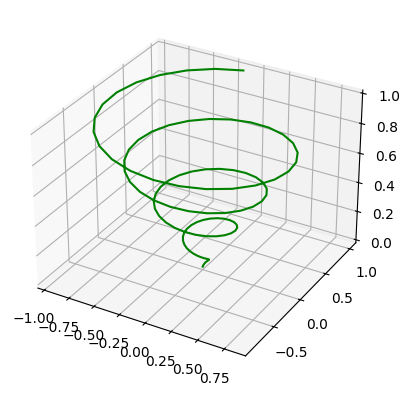

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
z = np.linspace(0, 1, 100)
x = z * np.sin(25 * z)
y = z * np.cos(25 * z)
ax.plot3D(x, y, z, 'green')
plt.show()

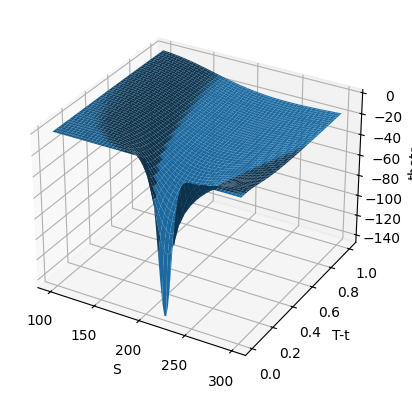

In [11]:
# stock price, time to maturity, theta

K = 220
r = 0.05
sigma = 0.32

S_range = np.linspace(100, 300, 100)
T_range = np.linspace(0.01, 1, 100)
S, T = np.meshgrid(S_range, T_range)
t = 0

theta_values = np.vectorize(theta)(S, K, T, t, r, sigma)

fig = plt.figure()
ax = plt.axes(projection='3d')
# z = np.linspace(0, 1, 100)
# x = z * np.sin(25 * z)
# y = z * np.cos(25 * z)
ax.plot_surface(S, T, theta_values)

ax.set_xlabel('S')
ax.set_ylabel('T-t')
ax.set_zlabel('theta')

plt.show()

# Monte Carlo

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  4 of 4 completed


Ticker
GOOGL    0.001070
INTC    -0.002017
NVDA     0.004720
SNAP     0.001561
dtype: float64
[0.00492611 0.00492611 0.00492611 0.98522167]
Summary for weights = [1, 1, 1, 200]:
Mean Final Value: $10,730.66
Variance of Final Value: 10,057,453.31
1st Quartile: $8,427.47
3rd Quartile: $12,482.18
Value at Risk (95% confidence): $6,563.00
Value at Risk (99% confidence): $5,099.49



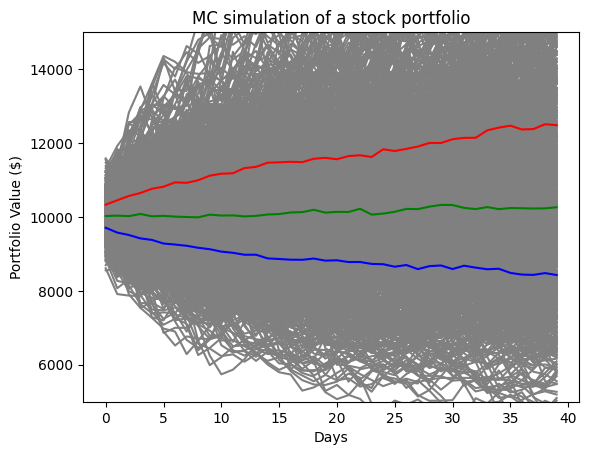

In [29]:
# df = pdr.DataReader('GE', 'yahoo', start='2019-09-10', end='2019-10-09')
# df.head()
import yfinance as yf
data = yf.download(["AAPL","NVDA"], start='2019-09-10', end='2020-10-09')
data.head()

def get_data(stock, start, end):
    stockData = yf.download(stock, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

stocks = ['NVDA', 'INTC', 'SNAP', 'GOOGL']
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

print(meanReturns)

# weights = np.random.random(len(meanReturns))
weights = [1, 1, 1, 200]
weights /= np.sum(weights)
weights2 = [200, 200, 200, 1]
weights2 /= np.sum(weights2)

print(weights)

# number of simulations
mc_sims = 1000
T = 40 # time frame in days

# arrays to store info
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns) # matrix
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range (0, mc_sims):
    # mc loops
    # you take a bunch of uncorrelated normally distributed samples and use Cholesky decomposition to produce normal vars with a given correlation
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) * initialPortfolio
percentiles = np.percentile(portfolio_sims, [25, 50, 75], axis=1)


plt.plot(portfolio_sims, color='grey')

plt.plot(percentiles[0, :], color='blue', label='25th Percentile')
plt.plot(percentiles[1, :], color='green', label='50th Percentile')
plt.plot(percentiles[2, :], color='red', label='75th Percentile')

# bottom, top = plt.ylim()  # return the current ylim
# plt.ylim((bottom, top))   # set the ylim to bottom, top
# plt.ylim(bottom, top)     # set the ylim to bottom, top

plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
# plt.ylim=(0, 1500)
# plt.xlim=(0,2)
plt.ylim(5000, 15000)
plt.title('MC simulation of a stock portfolio')

def print_summary(portfolio_sims, label):
    final_portfolio_values = portfolio_sims[-1, :]
    mean_final_value = np.mean(final_portfolio_values)
    var_final_value = np.var(final_portfolio_values)
    quart_25 = np.percentile(final_portfolio_values, 25)
    quart_75 = np.percentile(final_portfolio_values, 75)

    # 95% confidence that the portfolio will not get below VaR_95 in the given time period
    VaR_95 = np.percentile(final_portfolio_values, 5)
    VaR_99 = np.percentile(final_portfolio_values, 1)
    
    print(f"Summary for {label}:")
    print(f"Mean Final Value: ${mean_final_value:,.2f}")
    print(f"Variance of Final Value: {var_final_value:,.2f}")
    print(f"1st Quartile: ${quart_25:,.2f}")
    print(f"3rd Quartile: ${quart_75:,.2f}")
    print(f"Value at Risk (95% confidence): ${VaR_95:,.2f}")
    print(f"Value at Risk (99% confidence): ${VaR_99:,.2f}")
    print()

print_summary(portfolio_sims, "weights = [1, 1, 1, 200]")
# print_summary(portfolio_sims2, "weights2 = [200, 1, 1, 1]")


[0.3327787  0.3327787  0.3327787  0.00166389]
Summary for weights2 = [200, 200, 200, 1]:
Mean Final Value: $15,766.65
Variance of Final Value: 32,511,997.98
1st Quartile: $11,419.10
3rd Quartile: $18,956.35
Value at Risk (95% confidence): $8,263.12
Value at Risk (99% confidence): $6,286.14



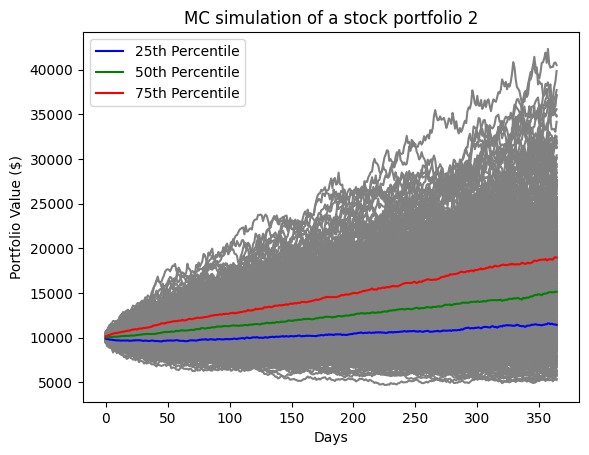

In [28]:
# number of simulations
mc_sims = 1000
T = 365 # time frame in days

# arrays to store info
meanM = np.full(shape=(T, len(weights2)), fill_value=meanReturns) # matrix
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

print(weights2)

for m in range (0, mc_sims):
    # mc loops
    # you take a bunch of uncorrelated normally distributed samples and use Cholesky decomposition to produce normal vars with a given correlation
    Z = np.random.normal(size=(T, len(weights2)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights2, dailyReturns.T) + 1) * initialPortfolio

percentiles = np.percentile(portfolio_sims, [25, 50, 75], axis=1)


plt.plot(portfolio_sims, color='grey')

plt.plot(percentiles[0, :], color='blue', label='25th Percentile')
plt.plot(percentiles[1, :], color='green', label='50th Percentile')
plt.plot(percentiles[2, :], color='red', label='75th Percentile')

# plt.ylim(6000, 15000)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio 2')

let = plt.legend()

print_summary(portfolio_sims, "weights2 = [200, 200, 200, 1]")
